In [1]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("ALE/SpaceInvaders-v5")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
class DQN(nn.Module):
    def __init__(self, num_frames, num_actions):
        super(DQN, self).__init__()
        self.num_frames = num_frames
        self.num_actions = num_actions
        
        # Layers
        self.conv1 = nn.Conv2d(
            in_channels=num_frames,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2
            )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
            )
        self.fc1 = nn.Linear(
            in_features=3200,
            out_features=256,
            )
        self.fc2 = nn.Linear(
            in_features=256,
            out_features=num_actions,
            )
        
        # Activation Functions
        self.relu = nn.ReLU()
    
    def flatten(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        return x
    
    def forward(self, x):
        
        # Forward pass
        x = self.relu(self.conv1(x))  # In: (80, 80, 4)  Out: (20, 20, 16)
        x = self.relu(self.conv2(x))  # In: (20, 20, 16) Out: (10, 10, 32)
        x = self.flatten(x)           # In: (10, 10, 32) Out: (3200,)
        x = self.relu(self.fc1(x))    # In: (3200,)      Out: (256,)
        x = self.fc2(x)               # In: (256,)       Out: (4,)
        
        return x

In [5]:
num_frames=4
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(num_frames, n_actions).to(device)
target_net = DQN(num_frames, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state,no_rand=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if no_rand or sample > eps_threshold:
        with torch.no_grad():
            #print("not random")
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state))
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
from skimage.color import rgb2gray
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
def process(state,device):
    state = rgb2gray(state[35:195, :, :])#state[0][35:195, :])#
    state = rescale(state, scale=0.5)
    state = state[np.newaxis, np.newaxis, :, :]
    return torch.tensor(state, device=device, dtype=torch.float)


In [19]:
import os
def save(model, t):
    save_path = os.path.join('ckpt', 'model-{}'.format(t))
    print("hi")
    torch.save(model.state_dict(), save_path)

/tmp/ipykernel_434/3096872390.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(range(num_episodes), unit='num_episodes')


  0%|          | 0/16000 [00:00<?, ?num_episodes/s]

Average reward (last 25 episodes): 418.60
Average reward (last 25 episodes): 339.80
Average reward (last 25 episodes): 397.40
Average reward (last 25 episodes): 369.60
Average reward (last 25 episodes): 361.60
Average reward (last 25 episodes): 387.20
Average reward (last 25 episodes): 396.40
Average reward (last 25 episodes): 376.40
Average reward (last 25 episodes): 399.60
Average reward (last 25 episodes): 471.20
Average reward (last 25 episodes): 421.60
Average reward (last 25 episodes): 366.60
Average reward (last 25 episodes): 367.40
Average reward (last 25 episodes): 410.40
Average reward (last 25 episodes): 373.60
Average reward (last 25 episodes): 395.20
Average reward (last 25 episodes): 362.40
Average reward (last 25 episodes): 450.00
Average reward (last 25 episodes): 359.20
Average reward (last 25 episodes): 345.60
Average reward (last 25 episodes): 415.60
Average reward (last 25 episodes): 380.00
Average reward (last 25 episodes): 423.00
Average reward (last 25 episodes):

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Average reward (last 25 episodes): 435.60
Average reward (last 25 episodes): 411.80
Average reward (last 25 episodes): 424.60
Average reward (last 25 episodes): 412.20
Average reward (last 25 episodes): 364.40
Average reward (last 25 episodes): 440.80
Average reward (last 25 episodes): 424.60
Average reward (last 25 episodes): 452.20
Average reward (last 25 episodes): 431.00
Average reward (last 25 episodes): 433.60
Average reward (last 25 episodes): 441.40
Average reward (last 25 episodes): 401.40
Average reward (last 25 episodes): 406.40
Average reward (last 25 episodes): 450.80
Average reward (last 25 episodes): 379.60
Average reward (last 25 episodes): 444.00
Average reward (last 25 episodes): 405.00
Average reward (last 25 episodes): 432.20
Average reward (last 25 episodes): 402.00
Average reward (last 25 episodes): 423.00
Average reward (last 25 episodes): 464.40
Average reward (last 25 episodes): 460.60
Average reward (last 25 episodes): 432.20
Average reward (last 25 episodes):

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Average reward (last 25 episodes): 404.40
Average reward (last 25 episodes): 443.40
Average reward (last 25 episodes): 449.60
Average reward (last 25 episodes): 429.00
Average reward (last 25 episodes): 432.40
Average reward (last 25 episodes): 460.00
Average reward (last 25 episodes): 513.60
Average reward (last 25 episodes): 434.20
Average reward (last 25 episodes): 416.40
Average reward (last 25 episodes): 423.00
Average reward (last 25 episodes): 440.40
Average reward (last 25 episodes): 418.20
Average reward (last 25 episodes): 463.80
Average reward (last 25 episodes): 433.20
Average reward (last 25 episodes): 399.00
Average reward (last 25 episodes): 445.40
Average reward (last 25 episodes): 456.40
Average reward (last 25 episodes): 451.00
Average reward (last 25 episodes): 439.20
Average reward (last 25 episodes): 500.40
Average reward (last 25 episodes): 415.80
Average reward (last 25 episodes): 436.00
Average reward (last 25 episodes): 413.80
Average reward (last 25 episodes):

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Average reward (last 25 episodes): 500.60
Average reward (last 25 episodes): 387.80
Average reward (last 25 episodes): 505.20
Average reward (last 25 episodes): 439.60
Average reward (last 25 episodes): 465.60
Average reward (last 25 episodes): 422.00
Average reward (last 25 episodes): 443.00
Average reward (last 25 episodes): 458.80
Average reward (last 25 episodes): 427.80
Average reward (last 25 episodes): 420.40
Average reward (last 25 episodes): 482.00
Average reward (last 25 episodes): 427.40
Average reward (last 25 episodes): 432.20
Average reward (last 25 episodes): 449.80
Average reward (last 25 episodes): 451.00
Average reward (last 25 episodes): 429.00
Average reward (last 25 episodes): 496.60
Average reward (last 25 episodes): 425.80
Average reward (last 25 episodes): 426.20
Average reward (last 25 episodes): 446.60
Average reward (last 25 episodes): 458.40
Average reward (last 25 episodes): 449.80
Average reward (last 25 episodes): 444.60
Average reward (last 25 episodes):

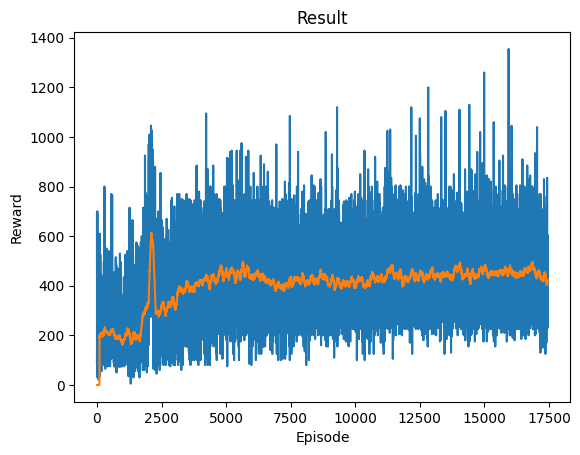

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
from tqdm import tqdm_notebook as tqdm
num_frames=4
if torch.cuda.is_available():
    num_episodes = 16000
else:
    num_episodes = 50
itters=0
rewards = []
try:
    progress_bar = tqdm(range(num_episodes), unit='num_episodes')
    for i_episode in progress_bar:
        # Initialize the environment and get its state
        state, info = env.reset()
        #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        state = process(state,device)
        reward_for_this_episode=0
        for t in count():
            itters+=1
            while state.size()[1] < num_frames:
                action = 1 # Fire
                #observation, reward, terminated, truncated, info
                new_frame, reward, done,truncated, info = env.step(action)
                new_frame = process(new_frame,device)
                state = torch.cat([state, new_frame], 1)

            #print(state.shape)                
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            new_frame = process(observation,device)
            new_state = torch.cat([state, new_frame], 1)
            new_state = new_state[:, 1:, :, :]

            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                new_state = None
            #else:
             #  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, new_state, reward)
            reward_for_this_episode += reward
            # Move to the next state
            #tate = next_state
            state = new_state
            if itters%4==0:
                # Perform one step of the optimization (on the policy network)
                optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(reward_for_this_episode)
                rewards.append(reward_for_this_episode.cpu())
                #plot_durations()
                break
        if i_episode % 25 == 0 and i_episode != 0:
            avg_return = np.mean(rewards[-25:])
            print("Average reward (last 25 episodes): {:.2f}".format(avg_return))
except KeyboardInterrupt:
    if 1==1:
        print("Saving model before quitting...")
        save(policy_net,itters)
    env.close()

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

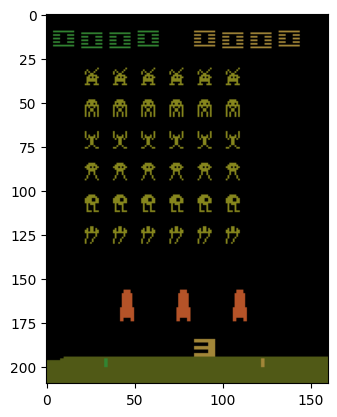

In [ ]:
import time
from skimage.color import rgb2gray
from skimage.transform import rescale
import numpy as np
num_frames=4
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
render=True
see_what_agent_sees=False

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = process(state,device)
    print(state[0])
    if render:
        if see_what_agent_sees:
            img = plt.imshow(state[0][0].cpu().numpy())
        else:
            img = plt.imshow(env.render())
    for t in count():
        if render:
            if see_what_agent_sees:
                img = plt.imshow(state[0][0].cpu().numpy())
            else:
                img = plt.imshow(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
        
        while state.size()[1] < num_frames:
            action = 1 # Fire
            #observation, reward, terminated, truncated, info
            new_frame, reward, done,truncated, info = env.step(action)
            new_frame = process(new_frame,device)
            state = torch.cat([state, new_frame], 1)
                        
        #print(state.shape)                
        action = select_action(state,no_rand=True)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        new_frame = process(observation,device)
        new_state = torch.cat([state, new_frame], 1)
        new_state = new_state[:, 1:, :, :]
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            new_state = None
        #else:
         #  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, new_state, reward)

        # Move to the next state
        #tate = next_state
        state = new_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
#!pip install gym[classic_control]